# Fianl Stage: Hybrid Link Prediction

## Construct the graph

### import & input

In [1]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import networkx as nx
import csv
import operator

In [3]:
from sklearn import cross_validation
from random import choice

In [4]:
import random

In [4]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

Hello, TensorFlow!


## Preprocessing

In [6]:
f_index = 'full_paper_index.txt'
f_links = 'full_paper_reference_links.txt'
d_index = pd.read_csv(f_index, sep='\t')
d_links = pd.read_csv(f_links, sep='\t')

In [6]:
d_index['title'][0]

'Complete Mining of Frequent Patterns from Graphs: Mining Graph Data'

Seems that some source papers appeared in reference_links are not in the index file. So use papers in index file to construct the mapper and consider them as nodes during computation. 

In [7]:
def construct_mapper(d, string):
    mapper={}
    for v in range(d.shape[0]):
        mapper.setdefault(v, d[string][v])
    print(v)
    return mapper

In [8]:
p_mapper = construct_mapper(d_index, 'paper_id')
a_mapper = construct_mapper(d_index, 'authors')
t_mapper = construct_mapper(d_index, 'title')

125916
125916
125916


In [9]:
def construct_mapper_r(d, string):
    mapper={}
    for v in range(d.shape[0]):
        mapper.setdefault(d[string][v], v)
    print(v)
    return mapper

In [10]:
p_mapper_r = construct_mapper_r(d_index, 'paper_id')
a_mapper_r = construct_mapper_r(d_index, 'authors')
t_mapper_r = construct_mapper_r(d_index, 'title')

125916
125916
125916


### Create reference graph using integers rather than indices in d_links

In [11]:
f = open('ref_graph.txt', 'w')
wr = csv.writer(f, delimiter='\t', quoting=csv.QUOTE_NONE)
for i in range(d_links.shape[0]):
    source = p_mapper_r.get(d_links['source'][i], -1)
    target = p_mapper_r.get(d_links['target'][i], -1)
    if (source != -1) and (target != -1):
        wr.writerow( (source, target) )
f.close()
ref_graph = np.loadtxt('ref_graph.txt', dtype='int', delimiter='\t')

In [5]:
ref_graph = np.loadtxt('ref_graph.txt', dtype='int', delimiter='\t')

## Construct the graphs
- Now we only need to use author_mapper2.txt, paper_mapper2.txt as mappers. 
- f_coauthor_links.txt and f_paper_reference_links.txt as edges. 

In [11]:
G_paper = nx.Graph()

In [12]:
G_paper.add_nodes_from(p_mapper.keys())

In [13]:
G_paper.add_edges_from(ref_graph)

## Link Predictions

In [ ]:
component_list = sorted(nx.connected_component_subgraphs(G_paper), key=len, reverse = True)
Gmax = component_list[0]

In [36]:
# load Gmax from file
Gmax = nx.DiGraph()
N = np.loadtxt('p_nodes')
Gmax.add_nodes_from(N)
E = np.loadtxt('p_edges')
Gmax.add_edges_from(E)

In [37]:
# Randomly sample 10% of the nodes to form a subgraph % to compatible with TF experiment, use 14010
num_of_nodes = len(Gmax.nodes())
nodeIndices = np.array(random.sample(range(num_of_nodes), 14010))
N = N[nodeIndices]
Gmax_sub = Gmax.subgraph(N)
# 6385 edges, 14040 nodes

In [41]:
# mask 10% of the edges
num_of_edges = len(Gmax_sub.edges())
testEdgeIndices = np.array(random.sample(range(len(Gmax_sub.edges())), int(0.1*len(Gmax_sub.edges()))))
trainEdgeIndices = np.setdiff1d(range(len(Gmax_sub.edges())), testEdgeIndices)

In [42]:
G_paper_train = nx.DiGraph()
G_paper_train.add_nodes_from(Gmax_sub.nodes())
G_paper_train.add_edges_from(np.array(Gmax_sub.edges())[trainEdgeIndices])

In [43]:
print num_of_edges
n = len(Gmax_sub.edges())-len(G_paper_train.edges())
print len(G_paper_train.edges())
print n

6385
5747
638


In [62]:
def node_write(element_list, filename):
    f = open(filename, 'w')
    wr = csv.writer(f, delimiter=':', quoting=csv.QUOTE_NONE)
    for element in element_list:
        wr.writerow( [element] )
    f.close()

In [76]:
def edge_write(edge_list, filename):
    f = open(filename, 'w')
    element_list = np.array(edge_list)
    wr = csv.writer(f, delimiter='\t', quoting=csv.QUOTE_NONE)
    for element in element_list:
        wr.writerow( (element[0], element[1]) )
    f.close()

In [77]:
node_write(list(G_paper_train.nodes()), 'G_paper_train_nodes.txt')
edge_write(G_paper_train.edges(), 'G_paper_train_edges.txt')

### Unsupervised: Jaccard, adamic/Adar

In [80]:
import heapq
def jaccard_sim(G):
    score = list(nx.jaccard_coefficient(G))
    # ranked_score = heapq.nlargest(N, score, key = operator.itemgetter(2))
    return score

In [79]:
def adamic_adar_sim(G):
    score = list(nx.adamic_adar_index(G))
    # ranked_score = heapq.nlargest(N, score, key = operator.itemgetter(2))
    return score

In [46]:
def result_writer(l, filename):
    f = open(filename, 'w')
    wr = csv.writer(f, delimiter=':', quoting=csv.QUOTE_NONE)
    for e in l:
        if e[2] != 0:
            wr.writerow(e)
    f.close

In [ ]:
jac_result = jaccard_sim(G_paper_train.to_undirected())
ada_result = adamic_adar_sim(G_paper_train.to_undirected())

In [239]:
result_writer(jac_result, 'jac_full')
result_writer(ada_result, 'ada_full')

In [99]:
jac = np.loadtxt('jac_full', delimiter=':')
ada = np.loadtxt('ada_full', delimiter=':')

## Link Prediction:: Supervised: Use title to judge similarity
    

In [81]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import KernelPCA
from sklearn import manifold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.ensemble import RandomForestClassifier

In [82]:
stops = set(stopwords.words("english"))
lmtzr = WordNetLemmatizer()

def pre_processing_a_sentence(sentence, method):
    if method == 'BoW':
        # remove punctuations
        sentence_without_puncs = re.sub("[^a-zA-Z0-9]", " ", sentence)
        # Tokenization
        words_in_sentence = sentence_without_puncs.lower().split()
        # Remove stop words
        words_in_sentence = [w for w in words_in_sentence if not w in stops]
        ## Wordlists
        # words_in_sentence = [w for w in words_in_sentence if not w in BASIC]
        # Lemmatize
        words_lemmatized_in_sentence = []
        for w in words_in_sentence:
            w = lmtzr.lemmatize(w, pos = 'v')
            words_lemmatized_in_sentence.append(w)
    else:
        # remove punctuations
        sentence_without_puncs = re.sub("[^a-zA-Z0-9]", " ", sentence)
        # Tokenization
        words_in_sentence = sentence_without_puncs.lower()
        
        n2 = ngrams(words_in_sentence, n=2, punctuation=".,;:!?()[]{}`''\"@#$^&*+-|=~_", continuous=False)
        joined_n2=[]
        for phrase_words in n2:
            joined_n2.append('-'.join(phrase_words))
            
        n3 = ngrams(words_in_sentence, n=3, punctuation=".,;:!?()[]{}`''\"@#$^&*+-|=~_", continuous=False)
        joined_n3=[]
        for phrase_words in n3:
            joined_n3.append('-'.join(phrase_words))
            
        words_lemmatized_in_sentence = []
        words_lemmatized_in_sentence.extend(joined_n2)
        words_lemmatized_in_sentence.extend(joined_n3)
        
    return words_lemmatized_in_sentence

def pre_processing(sentence_array, method):
    num = sentence_array.size
    words_array_clean = []
    
    # delete "NaN" (if there's any)
    sentence_array_nan_indices = pd.isnull(sentence_array)
    for i in xrange( 0, num ):
        if(sentence_array_nan_indices[i] == False):
            words_array_clean.append( str(pre_processing_a_sentence( sentence_array[i], method ) ) )
        else:
            words_array_clean.append( ' ' )
            
    return words_array_clean

vectorizer_title = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 10000) # 600*10 = 6000

def feature_generation(word_array, vectorizer):
    feature_array = vectorizer.fit_transform(word_array).toarray()
    feature_list = vectorizer.get_feature_names()
    return feature_array, feature_list

In [168]:
titles = np.array(d_index['title'])
w_title = pre_processing(titles, 'BoW')
feature_array_title, feature_list_title = feature_generation(w_title, vectorizer_title)

In [87]:
def PCA_analysis(feature_array, n):# find first n highest variances
    pca = PCA(n_components = n) 
    pca.fit(feature_array)
    feature_array_pca = pca.transform(feature_array)
    
    plt.figure(1)
    
    plt.subplot(211)
    plt.plot(pca.explained_variance_ratio_, 'ro')
    plt.ylabel('Percentage of variances')
    leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    
    plt.subplot(212)
    plt.plot(pca.singular_values_, 'bo')
    plt.ylabel('Singular values')
    leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    plt.show()
    
    return feature_array_pca

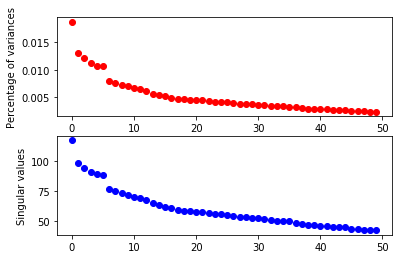

In [169]:
feature_array_title_pca = PCA_analysis(feature_array_title, 50)

In [170]:
np.shape(feature_array_title_pca)

(125917, 50)

In [91]:
def scatter_visualization_3D(data_array):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_array[:,0], data_array[:,1], data_array[:,2], c='red', s=10, label='Papers',
               alpha=0.3, edgecolors='none')
    ax.legend()
    ax.grid(True)
    plt.show()

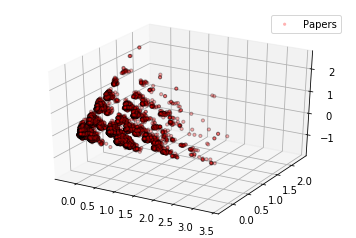

In [171]:
scatter_visualization_3D(feature_array_title_pca)

In [111]:
trainEdges = np.array(G_paper_train.edges()).astype(int)
trainNodes = np.array(G_paper_train.nodes()).astype(int)

In [133]:
testEdges = np.array(Gmax_sub.edges())[testEdgeIndices].astype(int)

In [471]:
len(trainFeatures)

96971

In [472]:
len(trainLabels)

96971

In [473]:
np.nonzero(np.array(trainLabels))[0].size

28820

In [470]:
trainFeatures = [] # size 96971
trainLabels = [] # size 96971, non zero elements 28820
trainDatas=[]
iter = 0
for i in trainNodes[np.random.choice(trainNodes.size, int(0.0005*trainNodes.size))]:
    iter+=1
    if iter % 100 == 0:
        print iter
    for j in trainNodes:#[np.random.choice(trainNodes.size, int(0.1*trainNodes.size))]:
        if i != j:
            if [i, j] in trainEdges:
                trainLabels.append(1)
            elif [i,j] in testEdges:
                continue
                trainLabels.append(-1)
            else:
                # ran = np.random.choice(2, 1, p=[0.9, 0.1])[0]
                trainLabels.append(0)
            for index in range(jac[:,0].size):
                if jac[index,0].astype(int)==i and jac[index,1].astype(int)==j:
                    jacada=[jac[index, 2], ada[index, 2]]
                else:
                    jacada=[0,0]
            trainFeatures.append(np.append(jacada, np.absolute(feature_array_title_pca[i][0:5]-feature_array_title_pca[j][0:5])))
            trainDatas.append([i,j])

In [477]:
len(testFeatures)

5743

In [478]:
np.nonzero(np.array(testLabels))[0].size

638

In [476]:
testFeatures = [] # 5743
testLabels = [] # 638 non zero elements
for [i,j] in testEdges:
    for index in range(jac[:,0].size):
        if jac[index,0].astype(int)==i and jac[index,1].astype(int)==j:
            jacada=[jac[index, 2], ada[index, 2]]
        else:
            jacada=[0,0]
    testLabels.append(1)
    testFeatures.append(np.append(jacada, np.absolute(feature_array_title_pca[i][0:5]-feature_array_title_pca[j][0:5])))
iter = 0
# 0 edges should from nodes within testEdges!!!
for i in trainNodes[np.random.choice(trainNodes.size, int(0.01*trainNodes.size))]:
    for j in trainNodes[np.random.choice(trainNodes.size, int(0.01*trainNodes.size))]:
        if iter > 638*8:
            break
        if i != j:
            if [i, j] in testEdges:
                continue
                testLabels.append(1)
            elif [i,j] in trainEdges:
                continue
                testLabels.append(-1)
            else:
                # ran = np.random.choice(2, 1, p=[0.9, 0.1])[0]
                iter+=1
                testLabels.append(0)
        for index in range(jac[:,0].size):
                if jac[index,0].astype(int)==i and jac[index,1].astype(int)==j:
                    jacada=[jac[index, 2], ada[index, 2]]
                else:
                    jacada=[0,0]
        testFeatures.append(np.append(jacada, np.absolute(feature_array_title_pca[i][0:5]-feature_array_title_pca[j][0:5])))

In [423]:
def test_train_writer(f,l,filename):
    fi = open(filename, 'w')
    wr = csv.writer(fi, delimiter=':', quoting=csv.QUOTE_NONE)
    for i in range(len(l)):
        wr.writerow((f[i][0], f[i][1], f[i][2], f[i][3], f[i][4],f[i][5],f[i][6], l[i]))
    fi.close()

In [479]:
test_train_writer(trainFeatures, trainLabels, 'trainData.txt')

In [480]:
test_train_writer(testFeatures, testLabels, 'testData.txt')

In [91]:
def similarity(a, b):
    s = np.dot(feature_array_title_pca[a], feature_array_title_pca[b].T)
    if s == 0:
        return s
    else:
        s = s / (np.linalg.norm(feature_array_title_pca[a])*np.linalg.norm(feature_array_title_pca[b]))
        return s

False

In [481]:
clf = RandomForestClassifier(
        criterion = 'entropy', #gini
        n_estimators=100, 
        max_depth = 25,   
        min_samples_leaf = 1,
        n_jobs = 16,
        random_state = 0
       )

In [490]:
w = np.array([3.6 if i==1 else 1 for i in trainLabels])

In [491]:
clf.fit(trainFeatures, trainLabels, sample_weight=w)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=16,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [492]:
print clf.score(trainFeatures, trainLabels)

0.989337018284


In [493]:
print clf.score(testFeatures, testLabels)

0.804457600557


### Try different similarity metrics

In [396]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [496]:
# NN
from sklearn.neural_network import MLPClassifier
clf2 = MLPClassifier(alpha=1) 
clf2.fit(trainFeatures, trainLabels) 
print clf2.score(trainFeatures, trainLabels) 
print clf2.score(testFeatures, testLabels)

0.702673995318
0.888385861048


### Thus, will use NN, and now evaluate it. 

In [302]:
node_mapper = {}
iter = 0 
for node in G_paper_train.nodes():
    node_mapper[node] = iter
    iter+=1

In [316]:
node_mapper_r = {}
iter = 0 
for node in G_paper_train.nodes():
    node_mapper_r[iter] = node
    iter+=1

In [231]:
remapped_edges = [(node_mapper[node1], node_mapper[node2]) for node1, node2 in list(G_paper_train.edges())]

In [232]:
remapped_edges = set(remapped_edges)

In [254]:
edge_list = list(Gmax_sub.edges())
test_edges = [edge_list[i] for i in testEdgeIndices]
remapped_test_edges = set([(node_mapper[node1], node_mapper[node2]) for node1, node2 in test_edges])

In [260]:
n = len(G_paper_train.nodes())

In [261]:
edges_to_sort = [[ j for j in range(n) if (i,j) not in remapped_edges ] for i in range(n)]

In [454]:
def get_feature(i,j):
    for index in range(jac[:,0].size):
        if jac[index,0]==node_mapper_r[i] and jac[index,1]==node_mapper_r[j]:
            jacada=[jac[index, 2], ada[index, 2]]
            break
        else:
            jacada=[0,0]
    feature = np.append(jacada, np.absolute(feature_array_title_pca[node_mapper_r[i].astype(int)][0:5]-feature_array_title_pca[node_mapper_r[j].astype(int)][0:5]))
    return feature

In [498]:
clf2.predict(np.array([0.0,0.0,0.03549223215032736,0.057131414154236601,0.025709844525961367,0.029162969157687443,0.058711345404273044]).reshape(1,-1))

array([0])

In [500]:
t0=time.time()
i = 16
nodes_to_sort = edges_to_sort[i]
p = heapq.nlargest(K, nodes_to_sort, key = lambda j : clf2.predict(get_feature(i,j).reshape(1,-1))[0])#PredictionMatrix[i][j])
t1 = time.time()-t0
print t1

90.3638470173


In [ ]:
HRS = []
hits = np.zeros(100)
K = 100
predicted = set()
for i in range(100):# n is too much
    nodes_to_sort = edges_to_sort[i]
    p = heapq.nlargest(K, nodes_to_sort, key = lambda j : clf2.predict(get_feature(i,j).reshape(1,-1))[0])#PredictionMatrix[i][j])
    for k in range(K):
        j = p[k]
        if (i,j) in remapped_test_edges: 
            for kk in range(k, K):
                hits[kk] = hits[kk] + 1

In [ ]:
for i in range(K):
    HRS.append(hits[i]/len(test_edges))

In [ ]:
plt.plot(HRS)
plt.show()

## Matrix factorization

In [273]:
np.array(list(G_paper_train.edges())).astype(int)

array([[ 32769, 108546],
       [     2, 116919],
       [     4,  10177],
       ..., 
       [ 32332,  32518],
       [ 32379,  32402],
       [107802,  65424]])

In [363]:
testEdgeIndices = np.array(random.sample(range(len(G_paper_train.edges())), int(0.1*len(G_paper_train.edges()))))
trainEdgeIndices = np.setdiff1d(range(len(G_paper_train.edges())), testEdgeIndices)
G_t = nx.DiGraph()
G_t.add_nodes_from(G_paper_train.nodes())
G_t.add_edges_from(np.array(list(G_paper_train.edges())).astype(int)[trainEdgeIndices])

In [364]:
P = nx.adjacency_matrix(G_t)

In [342]:
np.linalg.matrix_rank(Ptrain)

2272

In [384]:
Ptrain = P.todense()
n = P.shape[0]
print(Ptrain.shape)
k = 100
tf.reset_default_graph()
Pt = tf.get_variable("Ptrain", initializer = tf.constant(Ptrain.astype(np.float32)))
# Weights = tf.maximum(0.0001, Ptrain)
Weights = tf.maximum(0., Ptrain)
W = tf.get_variable("W", shape = [n,k])
H = tf.get_variable("H", shape = [n,k])
Prediction = tf.matmul(W, H, transpose_b = True)
Loss = tf.reduce_sum(tf.square(Prediction - Pt) * Weights)

reg_coeff = 0.00001
regularizer = reg_coeff * (tf.square(tf.norm(H)))

Loss = Loss + regularizer

learning_rate = 0.003
train_step = tf.train.AdamOptimizer(learning_rate).minimize(Loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(100):
        print(epoch)
        sess.run(train_step)
        current_loss = sess.run(Loss)
        print("loss = " + str(current_loss))
    PredictionMatrix = sess.run(Prediction)


(14010, 14010)
0
loss = 4593.17
1
loss = 4527.58
2
loss = 4456.81
3
loss = 4378.59
4
loss = 4291.46
5
loss = 4194.56
6
loss = 4087.38
7
loss = 3969.65
8
loss = 3841.29
9
loss = 3702.38
10
loss = 3553.13
11
loss = 3393.92
12
loss = 3225.26
13
loss = 3047.83
14
loss = 2862.48
15
loss = 2670.28
16
loss = 2472.47
17
loss = 2270.51
18
loss = 2066.09
19
loss = 1861.09
20
loss = 1657.63
21
loss = 1458.0
22
loss = 1264.67
23
loss = 1080.2
24
loss = 907.235
25
loss = 748.351
26
loss = 605.959
27
loss = 482.138
28
loss = 378.443
29
loss = 295.694
30
loss = 233.775
31
loss = 191.486
32
loss = 166.513
33
loss = 155.552
34
loss = 154.621
35
loss = 159.516
36
loss = 166.305
37
loss = 171.76
38
loss = 173.618
39
loss = 170.66
40
loss = 162.628
41
loss = 150.036
42
loss = 133.927
43
loss = 115.632
44
loss = 96.5553
45
loss = 77.9982
46
loss = 61.0397
47
loss = 46.4644
48
loss = 34.7355
49
loss = 26.0072
50
loss = 20.1634
51
loss = 16.8761
52
loss = 15.6717
53
loss = 15.9987
54
loss = 17.2902
55
loss =

In [314]:
node_mapper = {}
iter = 0 
for node in G_t.nodes():
    node_mapper[node] = iter
    iter+=1

In [315]:
remapped_edges = [(node_mapper[node1], node_mapper[node2]) for node1, node2 in list(G_t.edges())]

In [316]:
remapped_edges = set(remapped_edges)

In [ ]:
edge_list = list(G_paper_train.edges())
test_edges = [edge_list[i] for i in testEdgeIndices]
test_edges = set([(node_mapper[node1], node_mapper[node2]) for node1, node2 in test_edges])

In [366]:
edges_to_sort = [[ j for j in range(n) if (i,j) not in remapped_edges ] for i in range(n)]

In [367]:
K = 100
predicted = set()
for i in range(n):
    nodes_to_sort = edges_to_sort[i]
    p = heapq.nlargest(K, nodes_to_sort, key = lambda j : PredictionMatrix[i][j])
    for j in p:
        predicted.add( (i,j))

In [385]:
HRS = []
hits = np.zeros(100)
K = 100
predicted = set()
for i in range(n):
    nodes_to_sort = edges_to_sort[i]
    p = heapq.nlargest(K, nodes_to_sort, key = lambda j : PredictionMatrix[i][j])
    for k in range(K):
        j = p[k]
        if (i,j) in test_edges: 
            for kk in range(k, K):
                hits[kk] = hits[kk] + 1

In [386]:
for i in range(K):
    HRS.append(hits[i]/len(test_edges))

In [388]:
HRS

[0.3902439024390244,
 0.47212543554006969,
 0.50348432055749126,
 0.51567944250871078,
 0.52090592334494779,
 0.52264808362369342,
 0.52439024390243905,
 0.52439024390243905,
 0.52613240418118468,
 0.52787456445993031,
 0.53135888501742157,
 0.53135888501742157,
 0.5331010452961672,
 0.53484320557491294,
 0.53484320557491294,
 0.53484320557491294,
 0.53484320557491294,
 0.53484320557491294,
 0.53484320557491294,
 0.53658536585365857,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.54006968641114983,
 0.54006968641114983,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 

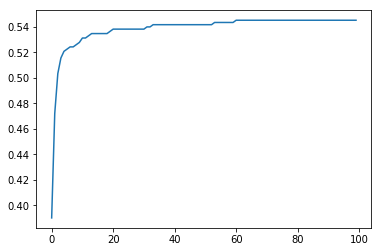

In [387]:
plt.plot(HRS)
plt.show()